In [300]:
import numpy as np
import matplotlib.pyplot as plt
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
from IPython.display import clear_output


## Transformation Functions

In [301]:
def rotation_matrix(theta, axis=2):
    """
    Calculates the rotation matrix of a rigid transformation with a rotation 
    theta in a given axis.

    Parameters
        -theta (float): rotation angle.
        -axis (int): axis in which the rotation happen.
        
    Returns
        -R (2d np.ndarray): rotation matrix.
    """
    if axis == 0:
        # Rotation in the X-axis
        return np.array([[ 1,              0,             0 ],
                         [ 0, np.cos(theta), -np.sin(theta) ],
                         [ 0, np.sin(theta),  np.cos(theta) ]])
    elif axis == 1:
        # Rotation in the Y-axis
        return np.array([[ np.cos(theta),  0, -np.sin(theta)],
                         [ 0,              1,             0 ],
                         [ np.sin(theta),  0, np.cos(theta) ]])
    else:
        # Rotation in the Z-axis
        return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                         [ np.sin(theta),  np.cos(theta), 0 ],
                         [ 0            ,  0            , 1 ]])
    

In [302]:
def homogeneous_transformation(origin, alpha, beta, gamma):
    """
    Calculates the homogeneous transformation matrix given the origin of
    the source coordinate system in relation to the destination coordinate system 
    and the euler angles.
    
    Parameters:
        -origin (1d np.ndarray): origin of the source coordinate system in relation
            to the destination coordinate system.
        -alpha (float): rotation angle in Z.
        -beta (float): rotation angle in Y.
        -gamma (float): rotation angle in X.
    
    Returns:
        -T (2d np.ndarray): homogeneous transformation matrix.
    """
    R = rotation_matrix(alpha, axis=0) @ rotation_matrix(beta, axis=1) @ rotation_matrix(gamma, axis=2)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = origin
    
    return T


In [303]:
def calculate_object_transformation(objHandle, refHandle):
    """
    Returns the homogeneous transformation matrix of an object given its handle
    and the reference handle.
    
    Parameters:
        -objHandle (int): handle of the target object.
        -refHandle (int): handle of the object to use as reference in the transformation.
    
    Returns:
        -T (2d np.ndarray): transformation matrix of the target object.        
    """
    position = sim.getObjectPosition(objHandle, refHandle)
    orientation = sim.getObjectOrientation(objHandle, refHandle)
    return homogeneous_transformation(position, *orientation)

In [304]:
def global_references(paths, save=False, filename='plot.png'):
    """
    Get the position and orientation of objects in relation to the global coordinates.
    
    Parameters:
        -paths (list): paths to the objects of the scene.
        -save (bool): whether the plot of the new coordinates should be saved.
        -filename (string): name of the file in which to save the plot.
    Returns:
        -global_refs (list): homogeneous transformation matrixes of the points.
    """
    global_refs = []
    for path in paths:
        handle = sim.getObject(path)
        T = calculate_object_transformation(handle, sim.handle_world)
        global_refs.append(T)
        
#     plot_references(*global_refs, label=paths, save=save, filename=filename)
    
    return global_refs

In [305]:
def transform_coordinates(origin, *args, label=[], save=False, filename='plot.png'):
    """
    Transform a set of points from one coordinate system to another.
    
    Parameters:
        -origin (2d np.ndarray): homogeneous transformation matrix of the point to be
            the origin of the coordinate system.
        -*args (list): points to be transformed.
        -label (list): label of the points.
        -save (bool): whether the plot of the new coordinates should be saved.
        -filename (string): name of the file in which to save the plot.
        
    Returns:
        -new_origin (2d np.ndarray): transformation matrix from the old coordinate system
            to the new one.
        -local_refs (list): points in the new coordinate system.
    """
    new_origin = np.eye(4)
    new_origin[:3, :3] = origin[:3, :3].T
    new_origin[:3, 3] = -origin[:3, :3].T @ origin[:3, 3]
    
    local_refs =[]
    for arg in args:
        local_refs.append(new_origin @ arg)
    
#     plot_references(*local_refs, label=label, save=save, filename=filename)
    
    return new_origin, local_refs
    

## Plot Functions

In [306]:
def plot_frame(Porg, R, c=None):
    """
    Plot the orientation of a body in the frame.
    
    Parameters:
        -Porg (1d np.ndarray): position of the body.
        -R (2d np.ndarray): rotation of the body.
    
    Returns:
        None.
    """
    axis_size = 1.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
    
    if c == None:
        c = ['r', 'g']   
        
    # X
    plt.quiver(*Porg[0:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    # Y
    plt.quiver(*Porg[0:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

In [307]:
def plot_references(*args, label=[], save=False, filename='plot.png'):
    # Plotting references
    plt.figure()
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(args))))
    
    # Plot the objects position and orientation
    for arg in args:
        c = next(color)
        plt.scatter(*arg[:2, 3], color=c, s=70)
    
    for arg in args:
        plot_frame(arg[:2, 3], arg[:3, :3])

    # Plot the relation between two objects
    for i in range(len(args) - 1):  
        relation = args[i][:2, 3] - args[i - 1][:2, 3]
        plt.quiver(*args[i - 1][:2, 3], *relation, color='grey', angles='xy', 
                   scale_units='xy', scale=1, alpha=0.8)
        
    # Add x and y axis lines    
    plt.axhline(0, color='black', linestyle='--', alpha=0.4)
    plt.axvline(0, color='black', linestyle='--', alpha=0.4)

    plt.axis('scaled')
    plt.axis((-5, 5, -5, 5))
    
    plt.legend(label, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Save figure in a PNG file
    if save:
        plt.savefig(filename)
    
    plt.show()
    

In [308]:
def plot_laser_points(laser_data, W_RT, laser_points, max_sensor_range=5,
                      savefig=False, filename='plot.png'):
    fig = plt.figure(figsize=(6,6), dpi=100)

    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            c = 'r'
            if ang < 0:    
                c = 'b'
            plt.plot(*laser_points[i, :2], 'o', color=c)
    
    # Desenha a localização do robô no plano
    plt.plot(*W_RT[:2, 3], marker='o', markersize=10, color='black')
    
    # Adiciona uma seta para representar a orientação do robô
    robot_orientation = np.arctan2(W_RT[1, 0], W_RT[0, 0])
    arrow_length = 1.0
    dx = arrow_length * np.cos(robot_orientation)
    dy = arrow_length * np.sin(robot_orientation)
    plt.arrow(*W_RT[:2, 3], dx, dy, color='black', head_width=0.2, head_length=0.3)
    
    plt.axis('scaled')
    plt.axis((-5, 5, -5, 5))
    plt.grid()
    
    if savefig:
        plt.savefig(filename)

    plt.show()
    

In [309]:
def plot_incremental_laser_detection(laser_data_history, W_RT_history, 
                                     laser_points_history, max_sensor_range=5,
                                     savefig=False, filename='plot.png'):

    fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    
    for laser_data, laser_points in zip(laser_data_history, laser_points_history):
        for i in range(len(laser_data)):
            ang, dist = laser_data[i]
            # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
            # Logo, usar um pequeno limiar do máximo para considerar a leitura
            if (max_sensor_range - dist) > 0.1:
                ax.plot(*laser_points[i, :2], 'o', color='black')
    
    # Desenha a localização do robô no plano
    for W_RT in W_RT_history:
        ax.plot(*W_RT[:2, 3], marker='*', markersize=10, color='grey')
    
        # Adiciona uma seta para representar a orientação do robô
        robot_orientation = np.arctan2(W_RT[1, 0], W_RT[0, 0])
        arrow_length = 0.4
        dx = arrow_length * np.cos(robot_orientation)
        dy = arrow_length * np.sin(robot_orientation)
        ax.arrow(*W_RT[:2, 3], dx, dy, color='grey', head_width=0.2, head_length=0.3)
    
    ax.axis('scaled')
    ax.axis((-5, 5, -5, 5))
    ax.grid()
    
    if savefig:
        plt.savefig(filename)

    plt.show()


## Execution

In [310]:
# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')


In [311]:
# Start simulation
sim.setStepping(False)
sim.startSimulation()


In [312]:
# Paths for the models of the scene
robot_path = '/Pioneer_p3dx'
paths = [robot_path, '/Bill', '/r2d2', '/240cmHighWallT', '/Bowl', '/conferenceChair']


### Calculate every transformation matrix for the global coordinates reference

The homogeneous transformation matrices in *global_refs* represent the
transformation of the object's local coordinates to global coordinates. In other words, if we have an object $O$, the elements of *global_refs* are the matrices $^{W}_{O}T$.

In [313]:
global_refs = global_references(paths)


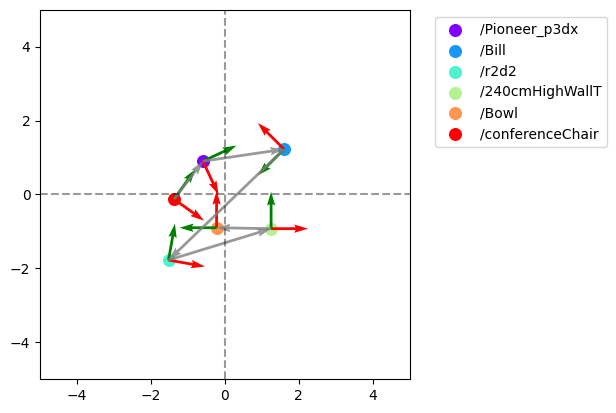

In [328]:
plot_references(*global_refs, label=paths)

### Calculate every transformation matrix for the local pioneer coordinates reference
We calculate the homogeneous transformations of the coordinates of the other objects $O$ in the scene to the coordinates of the pioneer $R$. In other words, the result of this operation are matrices of type $^{R}_{O}T$:
$$^{R}_{O}T = ^{R}_{W}T * ^{W}_{O}T = ^{W}_{R}T^{-1} * ^{W }_{O}T$$

In [325]:
W_RT = global_refs[0]
R_WT, local_refs = transform_coordinates(W_RT, *global_refs, label=paths[1:])

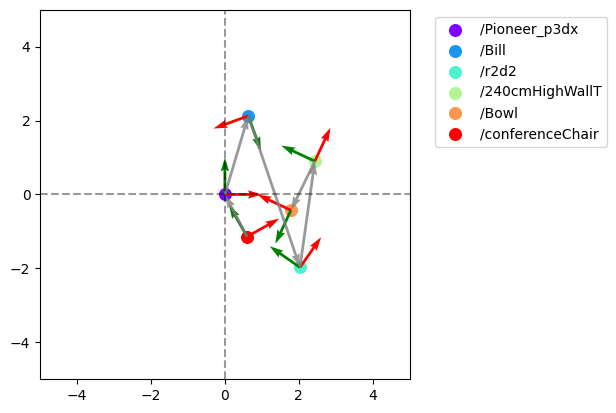

In [330]:
plot_references(*local_refs, label=paths)

## Working with Laser Sensors

### Function Definitions

In [315]:
# Extracted from github: https://github.com/verlab/dcc042-robotica-movel/blob/main/jupyter-notebooks/aula03-ferramental.ipynb

def read_sensor_data(range_data_signal_id="hokuyo_range_data", 
                   angle_data_signal_id="hokuyo_angle_data"):
    """
    It will try to capture the range and angle data from the simulator.
    The request for the range data is sent in streaming mode to force
    it to sync with the angle data request which acts as a mutex.

    Parameters:
        -clientId: simulator client id obtained through a successfull connection with the simulator.
        -range_data_signal_id: string containing the range data signal pipe name.
        -angle_data_signal_id: string containing the angle data signal pipe name.
    
    Returns:
        -returns None if no data is recovered.
        -returns two arrays, one with data range and the other with their angles, if data was 
            retrieved successfully.
    """
    # The first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)

    # The second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    string_angle_data = sim.waitForSignal(angle_data_signal_id)

    # Check the if both data were obtained correctly
    if string_range_data and string_angle_data:
        # Unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # Return none in case were nothing was gotten from the simulator
    return -1, -1


In [316]:
# Extracted from github: https://github.com/verlab/dcc042-robotica-movel/blob/main/jupyter-notebooks/aula03-ferramental.ipynb

def draw_laser_data(laser_data, max_sensor_range=5):
    
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

In [317]:
def handle_laser_data(laser_data, W_RT, W_LT, max_sensor_range=5):
    """
    This function takes laser data and transforms it from the laser
    reference frame to the global reference frame using provided
    transformation matrices. It calculates the detection points of
    the laser in both the local and global reference frames.

    Parameters:
        - laser_data (list): a list of tuples containing the
            angle and distance of laser detections.
        - W_RT (numpy.ndarray): transformation matrix for converting
            laser points from the local reference frame to the global
            reference frame.
        - W_LT (numpy.ndarray): transformation matrix for converting
            laser points from the global reference frame to the local
            reference frame.
        - max_sensor_range (float, optional): maximum sensor range for
            filtering laser detections. Defaults to 5 units.

    Returns:
        - global_laser_points (np.ndarray): an array of shape containing
            the laser detection points in the global reference frame.
        - local_laser_points (np.ndarray): an array of shape containing
            the laser detection points in the local reference frame.

    """
    # Calculate laser detection points in the laser reference frame
    local_laser_points = np.ones((len(laser_data), 4))
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        local_laser_points[i, 0] = dist * np.cos(ang)
        local_laser_points[i, 1] = dist * np.sin(ang)
        local_laser_points[i, 2] = 0
        
    # Calculate laser detection points in the global reference frame
    global_laser_points = np.dot(W_LT, local_laser_points.T).T

    return global_laser_points, local_laser_points


### Execution

In [318]:
# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Handle para o modelo do LASER
laser_path = '/Pioneer_p3dx/fastHokuyo'
laser_handle = sim.getObject(laser_path)

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas
while True:
    range_data = sim.getStringSignal(laser_range_data)
    if range_data:
        break


With the laser handles, we can read the sensors and plot the results according to the **robot reference.**

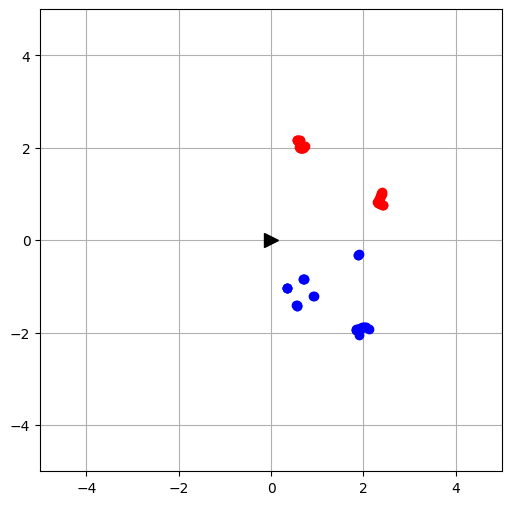

In [319]:
# Proceeding with the reading
raw_range_data, raw_angle_data = read_sensor_data(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T
draw_laser_data(laser_data)


We have the laser transformation matrix for the global coordinates ($^{W}_{L}T$) and the pioneer transformation matrix for the global coordinates ($^{W}_{R}T$) in *W_RT*. So, we want to calculate:
$$^{R}_{L}T = ^{R}_{W}T * ^{W}_{L}T$$ $$^{R}_{L}T = ^{W}_ {R}T^{-1} * ^{W}_{L}T$$

In [320]:
W_RT, W_LT = global_references([robot_path, laser_path])

In [321]:
R_WT, R_LT = transform_coordinates(W_RT, W_LT) 


We can see below the proof of the following equation:
$$^{W}_{R}T * ^{R}_{L}T = ^{W}_{L}T$$

In [322]:
np.round(W_RT @ R_LT, 3) == np.round(W_LT, 3)


array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

We can also make the necessary transformations to plot laser detections from a **global reference.**

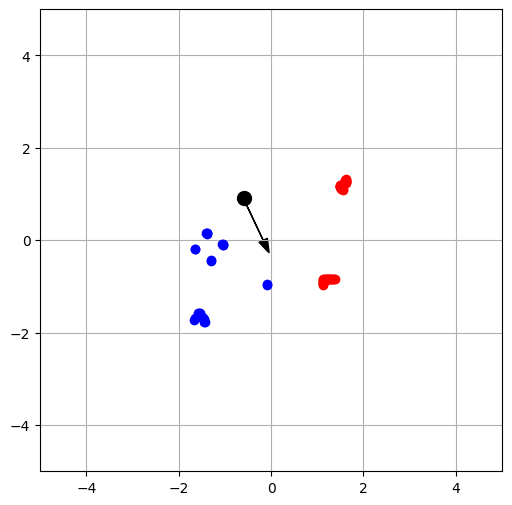

In [323]:
i = 1
while i < 10:
    clear_output(wait=True)
    
    # Read laser data
    raw_range_data, raw_angle_data = read_sensor_data(laser_range_data,
                                                      laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    
    # Calculate the position of the lasers and of the robot in the global reference
    W_RT, W_LT = global_references([robot_path, laser_path])
    
    # Get the result of the laser detection
    global_laser_points, local_laser_points = handle_laser_data(laser_data, W_RT, W_LT)
    
    # Plot the resulting points
    filename = f'laser{i}.png'
       
    plot_laser_points(laser_data, W_RT, global_laser_points, filename=filename)
        
    i += 1
    time.sleep(2)


Finally, we can **track the trajectory** of a robot through a scene. For that, we will use a simple locomotion script for the robot and an incremental plot.

**IN THE CELL BELOW WE WILL USE A DIFFERENT SCENE**

**ABAIXO USAMOS A CENA VISTA NA AULA TRÊS DA DISCIPLINA (DISPONIBILIZADA NO MOODLE)**

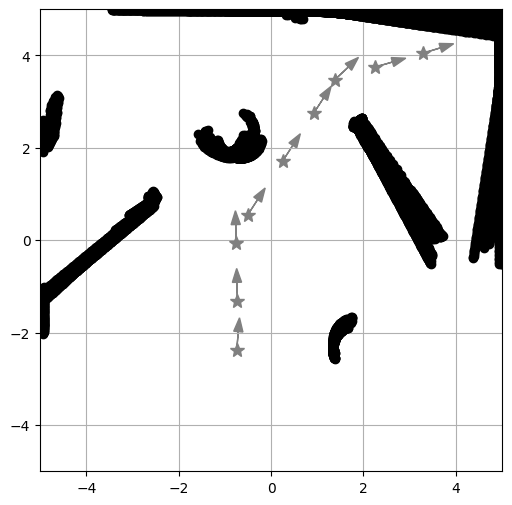

In [299]:
# Extracted from github: https://github.com/verlab/dcc042-robotica-movel/blob/main/jupyter-notebooks/aula03-ferramental.ipynb

# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')

sim.startSimulation()

l_wheel = sim.getObject(robot_path + '_leftMotor')
r_wheel = sim.getObject(robot_path + '_rightMotor')

# Dados para o plot incremental
gpoints_history = []
pose_history = []
laser_data_history = []
                                              
# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

t = 0
# Lembrar de habilitar o 'Real-time mode'
startTime = time.time()
lastTime = startTime
while t < 20:

    now = time.time()
    dt = now - lastTime

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = read_sensor_data(laser_range_data,
                                                  laser_angle_data)
    if raw_range_data == raw_angle_data == -1:
        break
        
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    laser_data_history.append(laser_data)
    
    # Calculate the position of the lasers and of the robot in the global reference
    W_RT, W_LT = global_references([robot_path, laser_path])
    pose_history.append(W_RT)
    
    # Get the result of the laser detection
    global_laser_points, local_laser_points = handle_laser_data(laser_data, W_RT, W_LT)
    gpoints_history.append(global_laser_points)

    # Velocidade básica (linear, angular)
    v = 0
    w = np.deg2rad(0)      

    frente = int(len(laser_data)/2)
    lado_direito = int(len(laser_data)*1/4)
    lado_esquerdo = int(len(laser_data)*3/4)

    if laser_data[frente, 1] > 2:
        v = .5
        w = 0
    elif laser_data[lado_direito, 1] > 2:
        v = 0
        w = np.deg2rad(-30)
    elif laser_data[lado_esquerdo, 1] > 2:
        v = 0
        w = np.deg2rad(30)

    # Isso é o modelo cinemático, estudaremos detalhadamente depois!
    wl = v/r - (w*L)/(2*r)
    wr = v/r + (w*L)/(2*r)

    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)  
    

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0) 

# Plotando caminho percorrido pelo robô
plot_incremental_laser_detection(laser_data_history, pose_history[::10], gpoints_history)


In [297]:
# End simulation
sim.stopSimulation()
